In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.spatial as spa
import scipy.stats as st
import scipy.linalg as linalg

In [2]:
# mean parameters
cluster_means = np.array([[+2.5, +2.5], 
                        [-2.5, +2.5], 
                        [-2.5, -2.5],
                        [+2.5, -2.5],
                        [-0.0, +0.0]])
# covariance parameters
cluster_covariances = np.array([[[+0.8, -0.6], 
                               [-0.6, +0.8]],
                              [[+0.8, +0.6], 
                               [+0.6, +0.8]],
                              [[+0.8, -0.6], 
                               [-0.6, +0.8]],
                              [[+0.8, +0.6], 
                               [+0.6, +0.8]],
                              [[+1.6, +0.0], 
                               [+0.0, +1.6]]])
# sample sizes
cluster_sizes = np.array([50, 50, 50, 50, 100])

In [3]:
# read data into memory
data_set = np.genfromtxt("hw07_data_set.csv", delimiter = ",")
initial_centroids = np.genfromtxt("hw07_initial_centroids.csv", delimiter = ",")

In [4]:
X = data_set

K = initial_centroids.shape[0]
N = X.shape[0]

In [5]:
def E_step(means, covariances, prior_probabilities, X):
    memberships = np.zeros((N, K))
    for k in range(K):
        for i in range(N):
            memberships[i, k] = st.multivariate_normal.pdf(X[i], means[k], covariances[k]) * prior_probabilities[k] / np.sum([st.multivariate_normal.pdf(X[i], means[c], covariances[c]) * prior_probabilities[c] for c in range(K)], axis = 0)
    return memberships

In [6]:
def M_step(memberships, X):
    means = np.zeros((K, X.shape[1]))
    covariances = np.zeros((K, X.shape[1], X.shape[1]))
    prior_probabilities = np.zeros((K))
    for k in range(K):
        means[k] = np.sum([np.multiply(X[i], memberships[i, k]) for i in range(N)], axis = 0) / np.sum(memberships[range(N), k])
        covariances[k] = np.sum([np.multiply(np.matmul(np.transpose(np.asmatrix(X[i] - means[k])), np.asmatrix(X[i] - means[k])), memberships[i, k]) for i in range(N)], axis = 0) / np.sum(memberships[range(N), k])
        prior_probabilities[k] = np.sum(memberships[range(N), k], axis = 0) / N
    return means, covariances, prior_probabilities

In [7]:
#initialization
means = initial_centroids

D = spa.distance_matrix(means, X)
memberships = np.zeros((N, K))
memberships[range(N), np.argmin(D, axis = 0)] = 1

covariances = np.zeros((K, X.shape[1], X.shape[1]))
for k in range(K):
    covariances[k] = np.sum([np.multiply(np.matmul(np.transpose(np.asmatrix(X[i] - means[k])), np.asmatrix(X[i] - means[k])), memberships[i, k]) for i in range(N)], axis = 0) / np.sum(memberships[range(N), k])

prior_probabilities = np.sum(memberships, axis = 0) / N

In [8]:
print(covariances)

[[[ 0.80960599 -0.46324747]
  [-0.46324747  3.80320539]]

 [[ 2.33101247 -0.30181859]
  [-0.30181859  0.38012916]]

 [[ 3.80999897  0.69724587]
  [ 0.69724587  0.8340096 ]]

 [[ 2.28896457  0.77160495]
  [ 0.77160495  1.17030957]]

 [[ 0.48980953  0.08037706]
  [ 0.08037706  0.53808927]]]


In [9]:
#iterations
for i in range(100):
    means, covariances, prior_probabilities = M_step(memberships, X)
    memberships = E_step(means, covariances, prior_probabilities, X)
    
print(means)

[[-2.44390049 -2.54539418]
 [ 2.50354332  2.51134858]
 [ 2.56726404 -2.55477253]
 [ 0.1279468   0.1559578 ]
 [-2.41465306  2.4855615 ]]


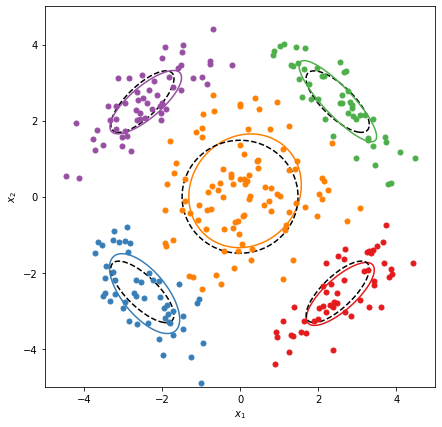

In [10]:
cluster_colors = np.array(["#377eb8", "#4daf4a", "#e41a1c", "#ff7f00", "#984ea3"])

fig = plt.figure(figsize = (7, 7))

memberships_final = np.argmax(memberships, axis = 1)

x1 = np.linspace(-5,5,1001)  
x2 = np.linspace(-5,5,1001)
XX, Y = np.meshgrid(x1, x2) 
pos = np.empty(XX.shape + (2,))                
pos[:, :, 0] = XX; pos[:, :, 1] = Y

for c in range(K):
    plt.plot(X[memberships_final == c, 0], X[memberships_final == c, 1], ".", markersize = 10, 
                color = cluster_colors[c])
    plt.contour(XX, Y, st.multivariate_normal(cluster_means[c], cluster_covariances[c]).pdf(pos), 1, colors = "black", linestyles = "dashed")
    plt.contour(XX, Y, st.multivariate_normal(means[c], covariances[c]).pdf(pos), 1, colors = cluster_colors[c], linestyles = "solid")
    
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.show()